In [9]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory

# === Step 1: Load dataset ===
train_ds = image_dataset_from_directory(
    "dataset/",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)

val_ds = image_dataset_from_directory(
    "dataset/",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(256, 256),
    batch_size=32
)

class_names = train_ds.class_names
print("Class names:", class_names)


Found 4110 files belonging to 2 classes.
Using 3288 files for training.
Found 4110 files belonging to 2 classes.
Using 822 files for validation.
Class names: ['Cape Sparrow', 'Squirrel']


In [10]:
# === Step 2 :Normalize pixel values to [0, 1] ===
normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

In [11]:
# === Shuffle, Prefetch, Cache ===
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.losses import BinaryCrossentropy
# === Step 5: Stronger custom CNN ===
model = models.Sequential([
    layers.Input(shape=(256, 256, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(
    256,
    activation='relu',
    kernel_regularizer=regularizers.l2(0.001)
),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(
    optimizer='adam',
    loss=BinaryCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,233,985 (50.48 MB)

 Trainable params: 13,233,985 (50.48 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# === Step 6: Train ===
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=[early_stop]
)

Epoch 1/40
103/103 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.5806 - loss: 0.9889 - val_accuracy: 0.7433 - val_loss: 0.5898
Epoch 2/40
103/103 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.7295 - loss: 0.5930 - val_accuracy: 0.7530 - val_loss: 0.5377
Epoch 3/40
103/103 ━━━━━━━━━━━━━━━━━━━━ 242s 2s/step - accuracy: 0.7629 - loss: 0.5327 - val_accuracy: 0.7640 - val_loss: 0.5502
Epoch 4/40
103/103 ━━━━━━━━━━━━━━━━━━━━ 255s 2s/step - accuracy: 0.7695 - loss: 0.5208 - val_accuracy: 0.7725 - val_loss: 0.5708
Epoch 5/40
103/103 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.7882 - loss: 0.4901 - val_accuracy: 0.8200 - val_loss: 0.4162
Epoch 6/40
103/103 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.7901 - loss: 0.4805 - val_accuracy: 0.7810 - val_loss: 0.5409
Epoch 7/40
103/103 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.7875 - loss: 0.4908 - val_accuracy: 0.7810 - val_loss: 0.6073
Epoch 8/40
103/103 ━━━━━━━━━━━━━━━━━━━━ 220s 2s/step - accuracy: 0.7942 - loss: 0.4646 - val_accu

In [4]:
model.save("squirrel_vs_sparrow_cnn_256_D_2025_07_16_R_1.keras")

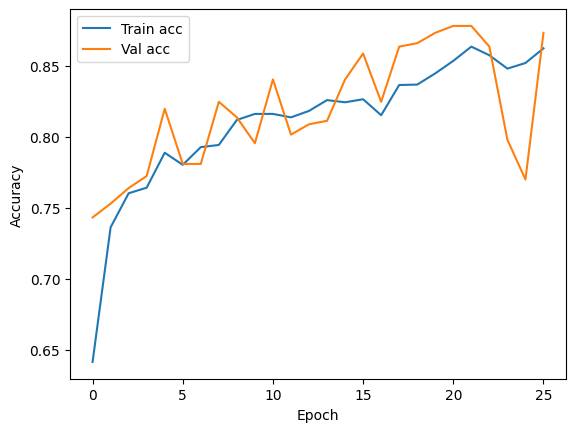

In [5]:
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
